## Neuro 1401: Building Models of the Brain
### Team: George Moe, Seeam Noor 
### Group 2: Project 1
### Harvard Spring 2021

1) Implement the normalization function (Equation 10 in Carandini & Heeger, 2012)
and show how this function removes redundancy in an input (i.e., by decorrelating
the pixels).

2) Show how the normalization function induces winner-take-all competition in a
population of neurons tuned to different orientations (see Figure 3e in Carandini &
Heeger, 2012).

3) Implement the adaptation version of normalization (Equation 12 in Carandini &
Heeger, 2012) and show how this produces light adaptation in the retina.

4) Discuss the empirical evidence for normalization in the visual system.

5) Discuss the possible biological mechanisms that could give rise to normalization.

References:
*Carandini, M. & Heeger, D.J. (2012). Normalization as a canonical neural operation.
Nature Reviews Neuroscience, 13, 51-62.*

In [209]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from PIL import Image, ImageOps 
import math

## Part 1

** Implement the normalization function (Equation 10 in Carandini & Heeger, 2012)
and show how this function removes redundancy in an input (i.e., by decorrelating
the pixels). **

1. Load input image
2. Apply normalization
3. Compare correlation between input and normalized images

In [2]:
# Loading image
image1 = Image.open('grating.png').convert('RGB')
image1_g = ImageOps.grayscale(image1) 
data1 = np.asarray(image1_g)
print("Shape of data: " + str(data1.shape))

Shape of data: (128, 128)


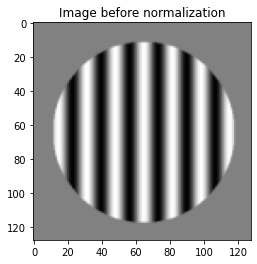

In [3]:
plt.imshow(image1_g, cmap='gray')
plt.title("Image before normalization")
plt.show()

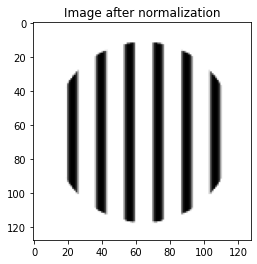

In [122]:
# Normalization function taken from paper - Equation 10 in Carandini & Heeger, 2012
def normalize1(d):
    '''
    Input: Takes an input value of a pixel
    Output: Returns the normalized version using Equation 10 in Carandini & Heeger, 2012
    '''
    r = ((d**n) * gamma)/(sigma**n + dsquaresum) 
    return r

# Exponentiation factor
n = 2

# Gamma has to be big otherwise the pixel values will be too small
gamma = 100000000000
sigma = 1

# Sum of the squares of all input
dsquaresum = np.sum(data1) ** n

vfunc = np.vectorize(normalize1)
normalized = vfunc(data1)
image1_normalized = Image.fromarray(normalized)
plt.imshow(image1_normalized)
plt.title("Image after normalization")
plt.show()

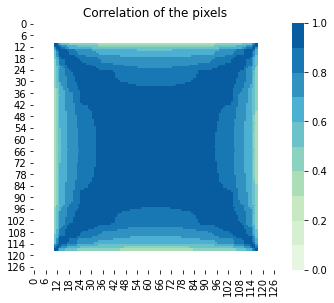

In [198]:
# Code for visualizing the correlations of the pixels
import seaborn as sns
def plotDataAndCov(data):
    ACov = np.corrcoef(data, rowvar=True)
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_size_inches(12, 10)
    ax0 = plt.subplot(2, 2, 1)
    ax0.set_title("Correlation of the pixels")
    # Choosing the colors
    cmap = sns.color_palette("GnBu", 10)
    sns.heatmap(ACov, cmap=cmap, vmin=0)

plotDataAndCov(data1)


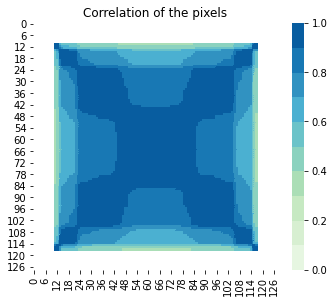

In [199]:
plotDataAndCov(normalized)

We can see that the pixels after using the normalizing function are much more decorrelated than the original one. Redundancies have been removed and the normalized image focuses on what's important.

## Part 2

** Show how the normalization function induces winner-take-all competition in a
population of neurons tuned to different orientations (see Figure 3e in Carandini &
Heeger, 2012). **

1. Load input image
2. Load filters
3. Apply filters to image
4. Normalize filter responses
5. Show how one filter does much better than the others after normalization

Here's the input image, converted to a grayscale luminosity array:

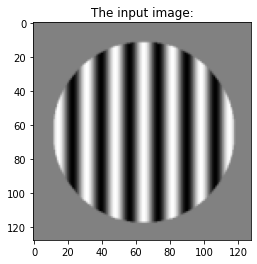

In [87]:
image2 = Image.open('grating.png') # shape: (128, 128, 4) [R, G, B, A]
image2 = image2.convert('L') # convert to grayscale (128, 128) [Luminosity]
image2 = np.array(image2) # Convert to array
image2 = image2 / 256 # Convert to [0, 1) value
plt.title("The input image:")
plt.imshow(image2, cmap='gray')

We simulate a neuron with preference for certain orientations with a Gabor filter.

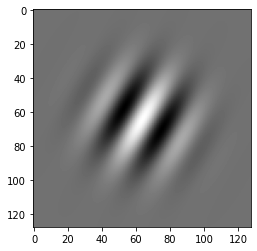

In [77]:
# Generate a gabor filter rotated to `orientation` degrees with pixel `size` width and height. `scale`
def make_filter(orientation, size):
    def filter_function(y, x):
        x_scaled = x / size - 0.5
        y_scaled = y / size - 0.5
        theta = (orientation + 90) / 180 * math.pi
        s = math.cos(theta) * x_scaled - math.sin(theta) * y_scaled

        scale=30
        cos_val = math.cos(s * scale)

        a = 1
        b = 0
        c = 0.15
        r = math.sqrt(x_scaled**2 + y_scaled**2)
        gauss_val = a * math.exp(-(r - b)**2 / (2 * c**2))
        return gauss_val * cos_val

    return np.fromfunction(np.vectorize(filter_function), (size, size))

# DEBUG: See one filter.
# plt.imshow(make_filter(60, 128))

filters = [make_filter(th, 128) for th in range(0, 180)]

plt.imshow(filters[60], cmap='gray')

# fig = plt.figure()
# for i, filt in enumerate(filters):
#     sub = fig.add_subplot(len(filters), 1, i + 1)
#     sub.imshow(filt, cmap='gray')

Here's that filter with orientations 0deg, 45deg, and 90deg applied to the original image.

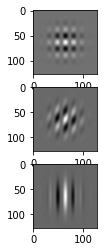

In [71]:
fig = plt.figure()
fig.set_size_inches(12, 10)
for i, filt in enumerate([filters[0], filters[45], filters[90]]):
    sub = fig.add_subplot(3, 1, i + 1)
    sub.imshow(image2 * filt, cmap='gray')

Here are the summed responses of each orientation:

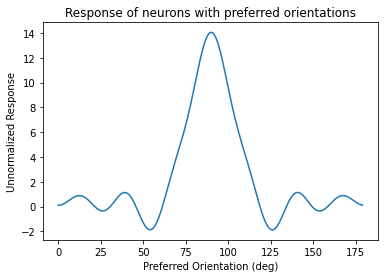

In [79]:
filter_responses = np.array([np.sum(image2 * filt) for filt in filters])
# for i, resp in enumerate(filter_responses):
#     print("FILTER", i, ":", resp)
plt.title("Response of neurons with preferred orientations")
plt.xlabel("Preferred Orientation (deg)")
plt.ylabel("Unnormalized Response")
plt.plot(filter_responses)
plt.show()

Here's a simple implementation of the normalization equation (vectorized):

In [74]:
def normalize(x, gamma, sigma, n):
    w_sum = np.sum(np.power(x, n))
    denom = math.pow(sigma, n) + w_sum
    return gamma * np.power(x, n) / denom

We apply this to the raw responses:

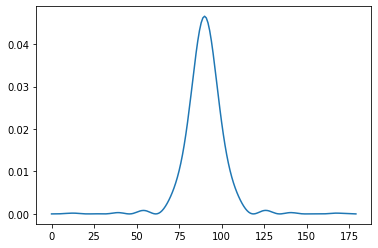

In [82]:
filter_responses_normed = normalize(filter_responses, 1, 1, 2)
plt.plot(filter_responses_normed)
plt.show()

Great! This is a lot less noisy, and there is a clear preferred orientation. This is a demonstration of how normalization can achieve winner-takes-all (max-pooling) in a population of neurons.

## Part 3

** Implement the adaptation version of normalization (Equation 12 in Carandini & Heeger, 2012) and show how this produces light adaptation in the retina. **

1. Load original image.
2. Produce some variations with different brightnesses.
3. Normalize those variations.
4. Treat these variations as increasing brightness over time; average them.
5. Compare the averaged outputs with the raw inputs.


We load the origianl image again.

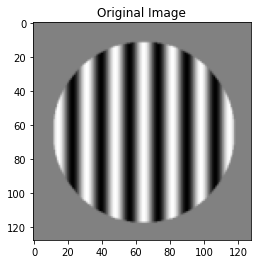

In [176]:
# Loading image
image1 = Image.open('grating.png').convert('RGB')
image1_g = ImageOps.grayscale(image1) 
data1 = np.asarray(image1_g)
plt.imshow(image1_g, cmap='gray')
plt.title("Original Image")
plt.show()

We increase the brightness of the image by biasing all the pixels upwards.

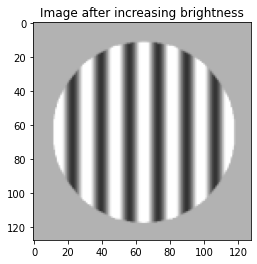

In [180]:
brightness = 50
data_b = np.minimum(data1.astype(np.int) + brightness, 255)
image1_b = Image.fromarray(data_b.astype(np.int8))
plt.imshow(image1_b, cmap='gray')
plt.title("Image after increasing brightness")
plt.show()

We decrease the brightness of the image by biasing the pixels downwards.

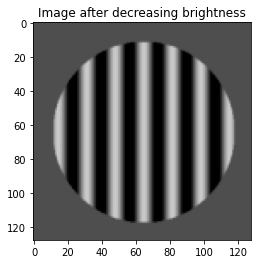

In [181]:
brightness = -50
data_c = np.maximum(data1.astype(np.int) + brightness, 0)
image1_c = Image.fromarray(data_c.astype(np.int8))
plt.imshow(image1_c, cmap='gray')
plt.title("Image after decreasing brightness")
plt.show()

Now let's normalize each of these. On the left, we see the raw input. On the right is the normalized output.

Nice! At least subjectively, while the inputs appear to differ in brightness, and lose contrast at lower and higher brightnesses, normalizing the input seems to preserve contrast.

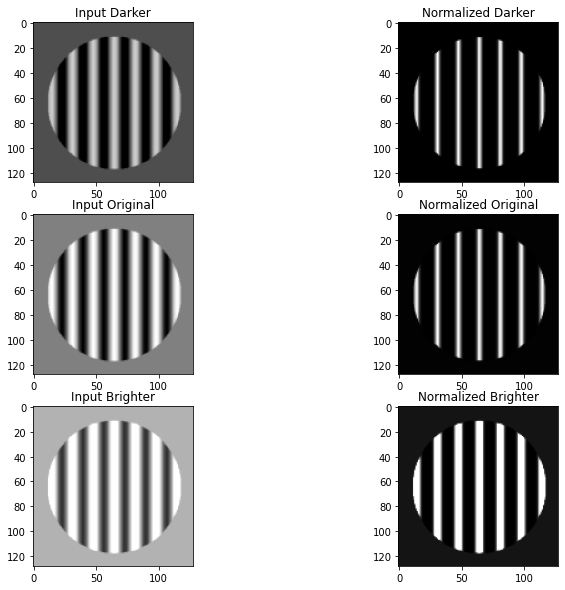

In [182]:
different_brightness_imgs = [
    data_c, # decreased brightness
    data1.astype(int), # original
    data_b  # increased brightness
]

fig = plt.figure()
fig.set_size_inches(12, 10)
for i, image_in in enumerate(different_brightness_imgs):
    sub = fig.add_subplot(len(different_brightness_imgs), 2, 2 * i + 1) 
    sub.title.set_text("Input " + ["Darker", "Original", "Brighter"][i])   
    sub.imshow(image_in.astype(int), cmap='gray', vmin=0, vmax=255)
    sub = fig.add_subplot(len(different_brightness_imgs), 2, 2 * i + 2)
    sub.title.set_text("Normalized " + ["Darker", "Original", "Brighter"][i])   
    sub.imshow(normalize(image_in.astype(int), 1, 1, 7), cmap='gray')

Let's now treat these differing inputs as input that varies over time.

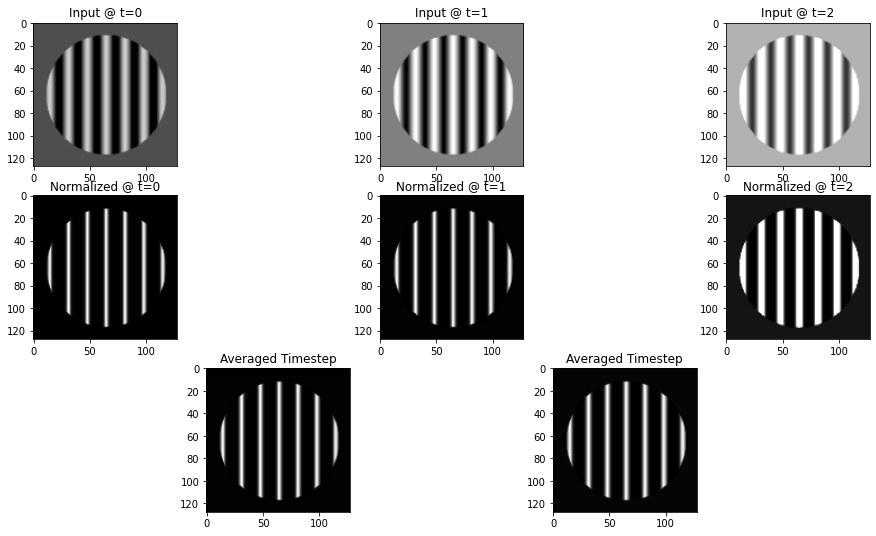

In [205]:
fig = plt.figure()
fig.set_size_inches(15,9)

# Inputs
sub = fig.add_subplot(3, 5, 1)
sub.imshow(data_c, cmap='gray', vmin=0, vmax=255)
sub.title.set_text("Input @ t=0")
sub = fig.add_subplot(3, 5, 3)
sub.imshow(data1, cmap='gray', vmin=0, vmax=255)
sub.title.set_text("Input @ t=1")
sub = fig.add_subplot(3, 5, 5)
sub.imshow(data_b, cmap='gray', vmin=0, vmax=255)
sub.title.set_text("Input @ t=2")

# Normalized
sub = fig.add_subplot(3, 5, 6)
sub.imshow(normalize(data_c.astype(int), 1, 1, 7), cmap='gray')
sub.title.set_text("Normalized @ t=0")
sub = fig.add_subplot(3, 5, 8)
sub.imshow(normalize(data1.astype(int), 1, 1, 7), cmap='gray')
sub.title.set_text("Normalized @ t=1")
sub = fig.add_subplot(3, 5, 10)
sub.imshow(normalize(data_b.astype(int), 1, 1, 7), cmap='gray')
sub.title.set_text("Normalized @ t=2")

# Averaged
avged1 = ( normalize(data_c.astype(int), 1, 1, 7) + normalize(data1.astype(int), 1, 1, 7) ) / 2
avged2 = ( normalize(data1.astype(int), 1, 1, 7) + normalize(data_b.astype(int), 1, 1, 7) ) / 2
sub = fig.add_subplot(3, 5, 12)
sub.imshow(avged1, cmap='gray')
sub.title.set_text("Averaged Timestep")
sub = fig.add_subplot(3, 5, 14)
sub.title.set_text("Averaged Timestep")
sub.imshow(avged2, cmap='gray')

Great! After averaging the normalized inputs over time, we see even more clearly how normalization + averaging can produce stable visual input even in the face of varying brightness. 

This could be very applicable in a real-world system, as brightness information vary all the time (such as due to overcorrections in the iris or moving clouds).

The pixels of the normalized image are very correlated.

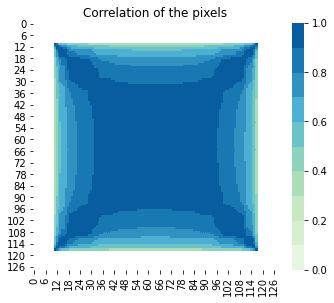

In [203]:
# Plotting the correlation of pixels
plotDataAndCov(image1_b)

Below we can see that the normalized image has removed redundancies and focuses on edges and key information. 

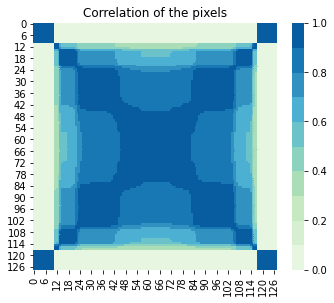

In [208]:
# Plotting the correlation of normalized image
plotDataAndCov(normalize(data_b, 1, 1, 7))

We can see that the pixels after using the normalizing function are much more decorrelated than the original one. Redundancies have been removed and the normalized image focuses on what's important (information and edge).

## Part 4

** Discuss the empirical evidence for normalization in the visual system.**

There is increasing evidence that the brain relies on canonical neural computations like normalization across brain regions. A few such examples have been given below.

1. Normalization in the invertebrate olfactory system:

    In the fruitfly (*Drosophila melanogaster*), we can see that they sense odours through receptor neurons, each of which expresses a single odorant receptor. If we look at the responses of olfactory neurons in the antennal lobe to test odorant in the presence of mask odorants of increasing concentration we can see that the curves are fits of the normalization model.


2. Normalization in the retina:

    The retina also needs to operate in a wide range of light intensities. Light intensities can range over 10 factors of 10. Light adaptation adjusts the sensitivity of neurons in the retina through normalization. Normalization makes photoreceptors adjust their operating point to discount mean light intensity. 


3. Normalization in the primary visual cortex:

    Normalization also occurs at multiple subsequent stages along the visual pathway. For instance, there is evidence that normalization happens for a population of V1 neurons differing in preference for stimulus position and orientation. Normalization explains why responses of V1 neurons saturate with increasing stimulus contrast, irrespective of stimulus orientation, and therefore irrespective of firing rate. Normalization also accounts for surround suppression.



## Part 5

** Discuss the possible biological mechanisms that could give rise to normalization.**

There are a variety of proposed biological mechanism for how neurons implement normalizaiton. On a structural level, it could be accomplished by

* A feedforward network, since outputs of the normalization equation only depend on inputs (no loops).
* A reinforcing feedback network, which uses pooled values to inhibit/excite inputs to get the desired gain.

There are also questions of how "division" might arise from neurons. Some proposed mechanisms are:

* Shunting inhibition, in which the *conductance* (1/resistance) of the neural membrane is changed in a way that *inversely* affects the time constant of responses (which is proportional to resistance, a la RC circuit).
* Nonlinearities in input by synaptic depression, in which some neurons experience reduced effectiveness that is similar to division.
* Fluctuating baseline level of ongoing activity in the wider brain that controls responsiveness of neurons, which can cause them to become less responsive when stimulus contrast increses, mimicking suppression and producing a divisive result.
* Controlling amplification instead of inhibition.


** References: **

* Main Paper: https://www.nature.com/articles/nrn3136

* Image Correlation: https://stackoverflow.com/questions/3689840/how-to-find-correlation-of-an-image

* Gabor Filter (Wikipedia): https://en.wikipedia.org/wiki/Gabor_filter

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c1ca5aba-a7fb-4aa2-adf1-4166df985120' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>